In [1]:
!pip install -q openai pillow

In [59]:
import os
import cv2
import numpy as np
import base64
import io
import json
from openai import OpenAI
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
from IPython.display import display, Markdown
import zipfile

In [3]:
api_key = "KEY"

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)

In [4]:
def encode_image_to_base64(image_path):
    with Image.open(image_path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB')

        buffered = io.BytesIO()
        img.save(buffered, format="JPEG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')

In [15]:
def extract_json_from_response(result):
    try:
        # Extract JSON from response
        if "```json" in result:
            result = result.split("```json")[1].split("```")[0].strip()
        elif "```" in result:
            result = result.split("```")[1].split("```")[0].strip()

        rooms = json.loads(result)
        return rooms
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        print(f"Response was: {result}")
        return []

In [17]:
def analyze_floor_plan(image_path, query=None):
    if query is None:
        query = """
        Analyze this architectural floor plan carefully. Provide specific numbers.

        1. DIMENSIONS:
           - Plot width (meters)
           - Plot depth (meters)
           - Total area (square meters)

        2. ROOMS:
           - Count bedrooms
           - Count bathrooms/WC
           - Kitchen (yes/no)
           - Living room (yes/no)
           - Dining room (yes/no)
           - Storage rooms

        3. PARKING:
           - Number of car parking spaces

        4. OUTDOOR:
           - Lawn areas count
           - Flower beds count
        """

    base64_image = encode_image_to_base64(image_path)

    try:
        response = client.chat.completions.create(

          model="qwen/qwen-vl-max",
          messages=[
            {
              "role": "user",
              "content": [
                  {"type": "text", "text": query},
                  {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                  },
              ],
            },
          ],
          max_tokens=1024,
        )
        return response.choices[0].message.content.strip()
        rooms = extract_json_from_response(result)
        return rooms

    except Exception as e:
        print(f"An error occurred: {e}")
        return f"An error occurred: {e}"

In [63]:
def detect_rooms(image_path):
    # Read image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to get binary image
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Remove small noise
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by area (rooms should have reasonable size)
    height, width = gray.shape
    min_area = (width * height) * 0.001
    max_area = (width * height) * 0.3

    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / h if h > 0 else 0
            if 0.3 < aspect_ratio < 3.0:
                valid_contours.append({
                    'contour': contour,
                    'bbox': [x, y, x+w, y+h],
                    'area': area
                })
    #sort by area
    valid_contours.sort(key=lambda x: x['area'], reverse=True)

    return valid_contours, img

In [64]:
def match_contours_to_rooms(contours, room_data):
    matched_rooms = []

    for room in room_data:
        name = room['name']
        ai_bbox = room['bbox']

        # Calculate center point of AI-detected room
        ai_center_x = (ai_bbox[0] + ai_bbox[2]) / 2
        ai_center_y = (ai_bbox[1] + ai_bbox[3]) / 2

        # Find closest contour
        best_match = None
        min_distance = float('inf')

        for i, contour_data in enumerate(contours):
            cv_bbox = contour_data['bbox']
            cv_center_x = (cv_bbox[0] + cv_bbox[2]) / 2
            cv_center_y = (cv_bbox[1] + cv_bbox[3]) / 2

            # Calculate distance between centers
            distance = np.sqrt((ai_center_x - cv_center_x)**2 +
                             (ai_center_y - cv_center_y)**2)

            if distance < min_distance:
                min_distance = distance
                best_match = i

        # Use CV-detected bbox if match is reasonable
        if best_match is not None and min_distance < 200:
            matched_rooms.append({
                'name': name,
                'bbox': contours[best_match]['bbox'],
                'source': 'cv_matched'
            })
        else:
            matched_rooms.append({
                'name': name,
                'bbox': ai_bbox,
                'source': 'ai_fallback'
            })

    return matched_rooms

In [65]:
def sift(image_path, rooms):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    refined_rooms = []

    for room in rooms:
        name = room['name']
        bbox = room['bbox']

        # Extract room region
        x1, y1, x2, y2 = bbox
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(img.shape[1], x2), min(img.shape[0], y2)

        if x2 <= x1 or y2 <= y1:
            continue

        room_region = gray[y1:y2, x1:x2]

        if room_region.size == 0:
            continue

        # Detect keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(room_region, None)

        # Refine bbox based on keypoint distribution
        if len(keypoints) > 4:
            kp_coords = np.array([kp.pt for kp in keypoints])

            # Find min/max to tighten bbox
            min_x = int(np.min(kp_coords[:, 0]))
            max_x = int(np.max(kp_coords[:, 0]))
            min_y = int(np.min(kp_coords[:, 1]))
            max_y = int(np.max(kp_coords[:, 1]))

            # Add padding
            padding = 10
            min_x = max(0, min_x - padding)
            min_y = max(0, min_y - padding)
            max_x = min(room_region.shape[1], max_x + padding)
            max_y = min(room_region.shape[0], max_y + padding)

            # Convert back to full image coordinates
            refined_bbox = [x1 + min_x, y1 + min_y, x1 + max_x, y1 + max_y]
        else:
            refined_bbox = bbox

        refined_rooms.append({
            'name': name,
            'bbox': refined_bbox,
            'keypoints': len(keypoints)
        })

    return refined_rooms


In [87]:
def segment(image_path, rooms, output_dir="room_segments_cv"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    original_img = Image.open(image_path)
    width, height = original_img.size

    annotated_img = original_img.copy()
    draw = ImageDraw.Draw(annotated_img)

    saved_segments = []

    for i, room in enumerate(rooms):
        name = room.get('name', f'Room_{i}')
        bbox = room.get('bbox', [])

        if len(bbox) != 4:
            continue

        x_min, y_min, x_max, y_max = bbox
        SCALE_FACTOR=1.8
        # Validate coordinates
        x_min = max(0, min(int(x_min), width))* SCALE_FACTOR
        x_max = max(0, min(int(x_max), width))* SCALE_FACTOR
        y_min = max(0, min(int(y_min), height))* SCALE_FACTOR
        y_max = max(0, min(int(y_max), height))* SCALE_FACTOR

        if x_max <= x_min or y_max <= y_min:
            print(f"Invalid coordinates for {name}")
            continue

        width_px = x_max - x_min
        height_px = y_max - y_min

        if width_px < 20 or height_px < 20:
            print(f"Skipping {name}: too small ({width_px}x{height_px})")
            continue

        print(f"Processing {name}: {width_px}x{height_px} pixels")

        # Draw rectangle
        draw.rectangle([x_min, y_min, x_max, y_max], outline="blue", width=3)
        draw.text((x_min + 5, y_min + 5), name, fill="blue")

        # Crop and save
        cropped = original_img.crop((x_min, y_min, x_max, y_max))
        safe_name = "".join(c for c in name if c.isalnum() or c in (' ', '-', '_')).strip()
        filename = f"{i+1:02d}_{safe_name}.png"
        filepath = os.path.join(output_dir, filename)
        cropped.save(filepath)

        saved_segments.append({
            'name': name,
            'file': filename,
            'bbox': [x_min, y_min, x_max, y_max]
        })

    # to save image
    annotated_path = os.path.join(output_dir, "00_annotated_floor_plan.png")
    annotated_img.save(annotated_path)

    return saved_segments, annotated_img


In [7]:
def ask_question(image_path, question):
    return analyze_floor_plan(image_path, question)

Saving Screenshot 2025-11-06 000232.png to Screenshot 2025-11-06 000232.png


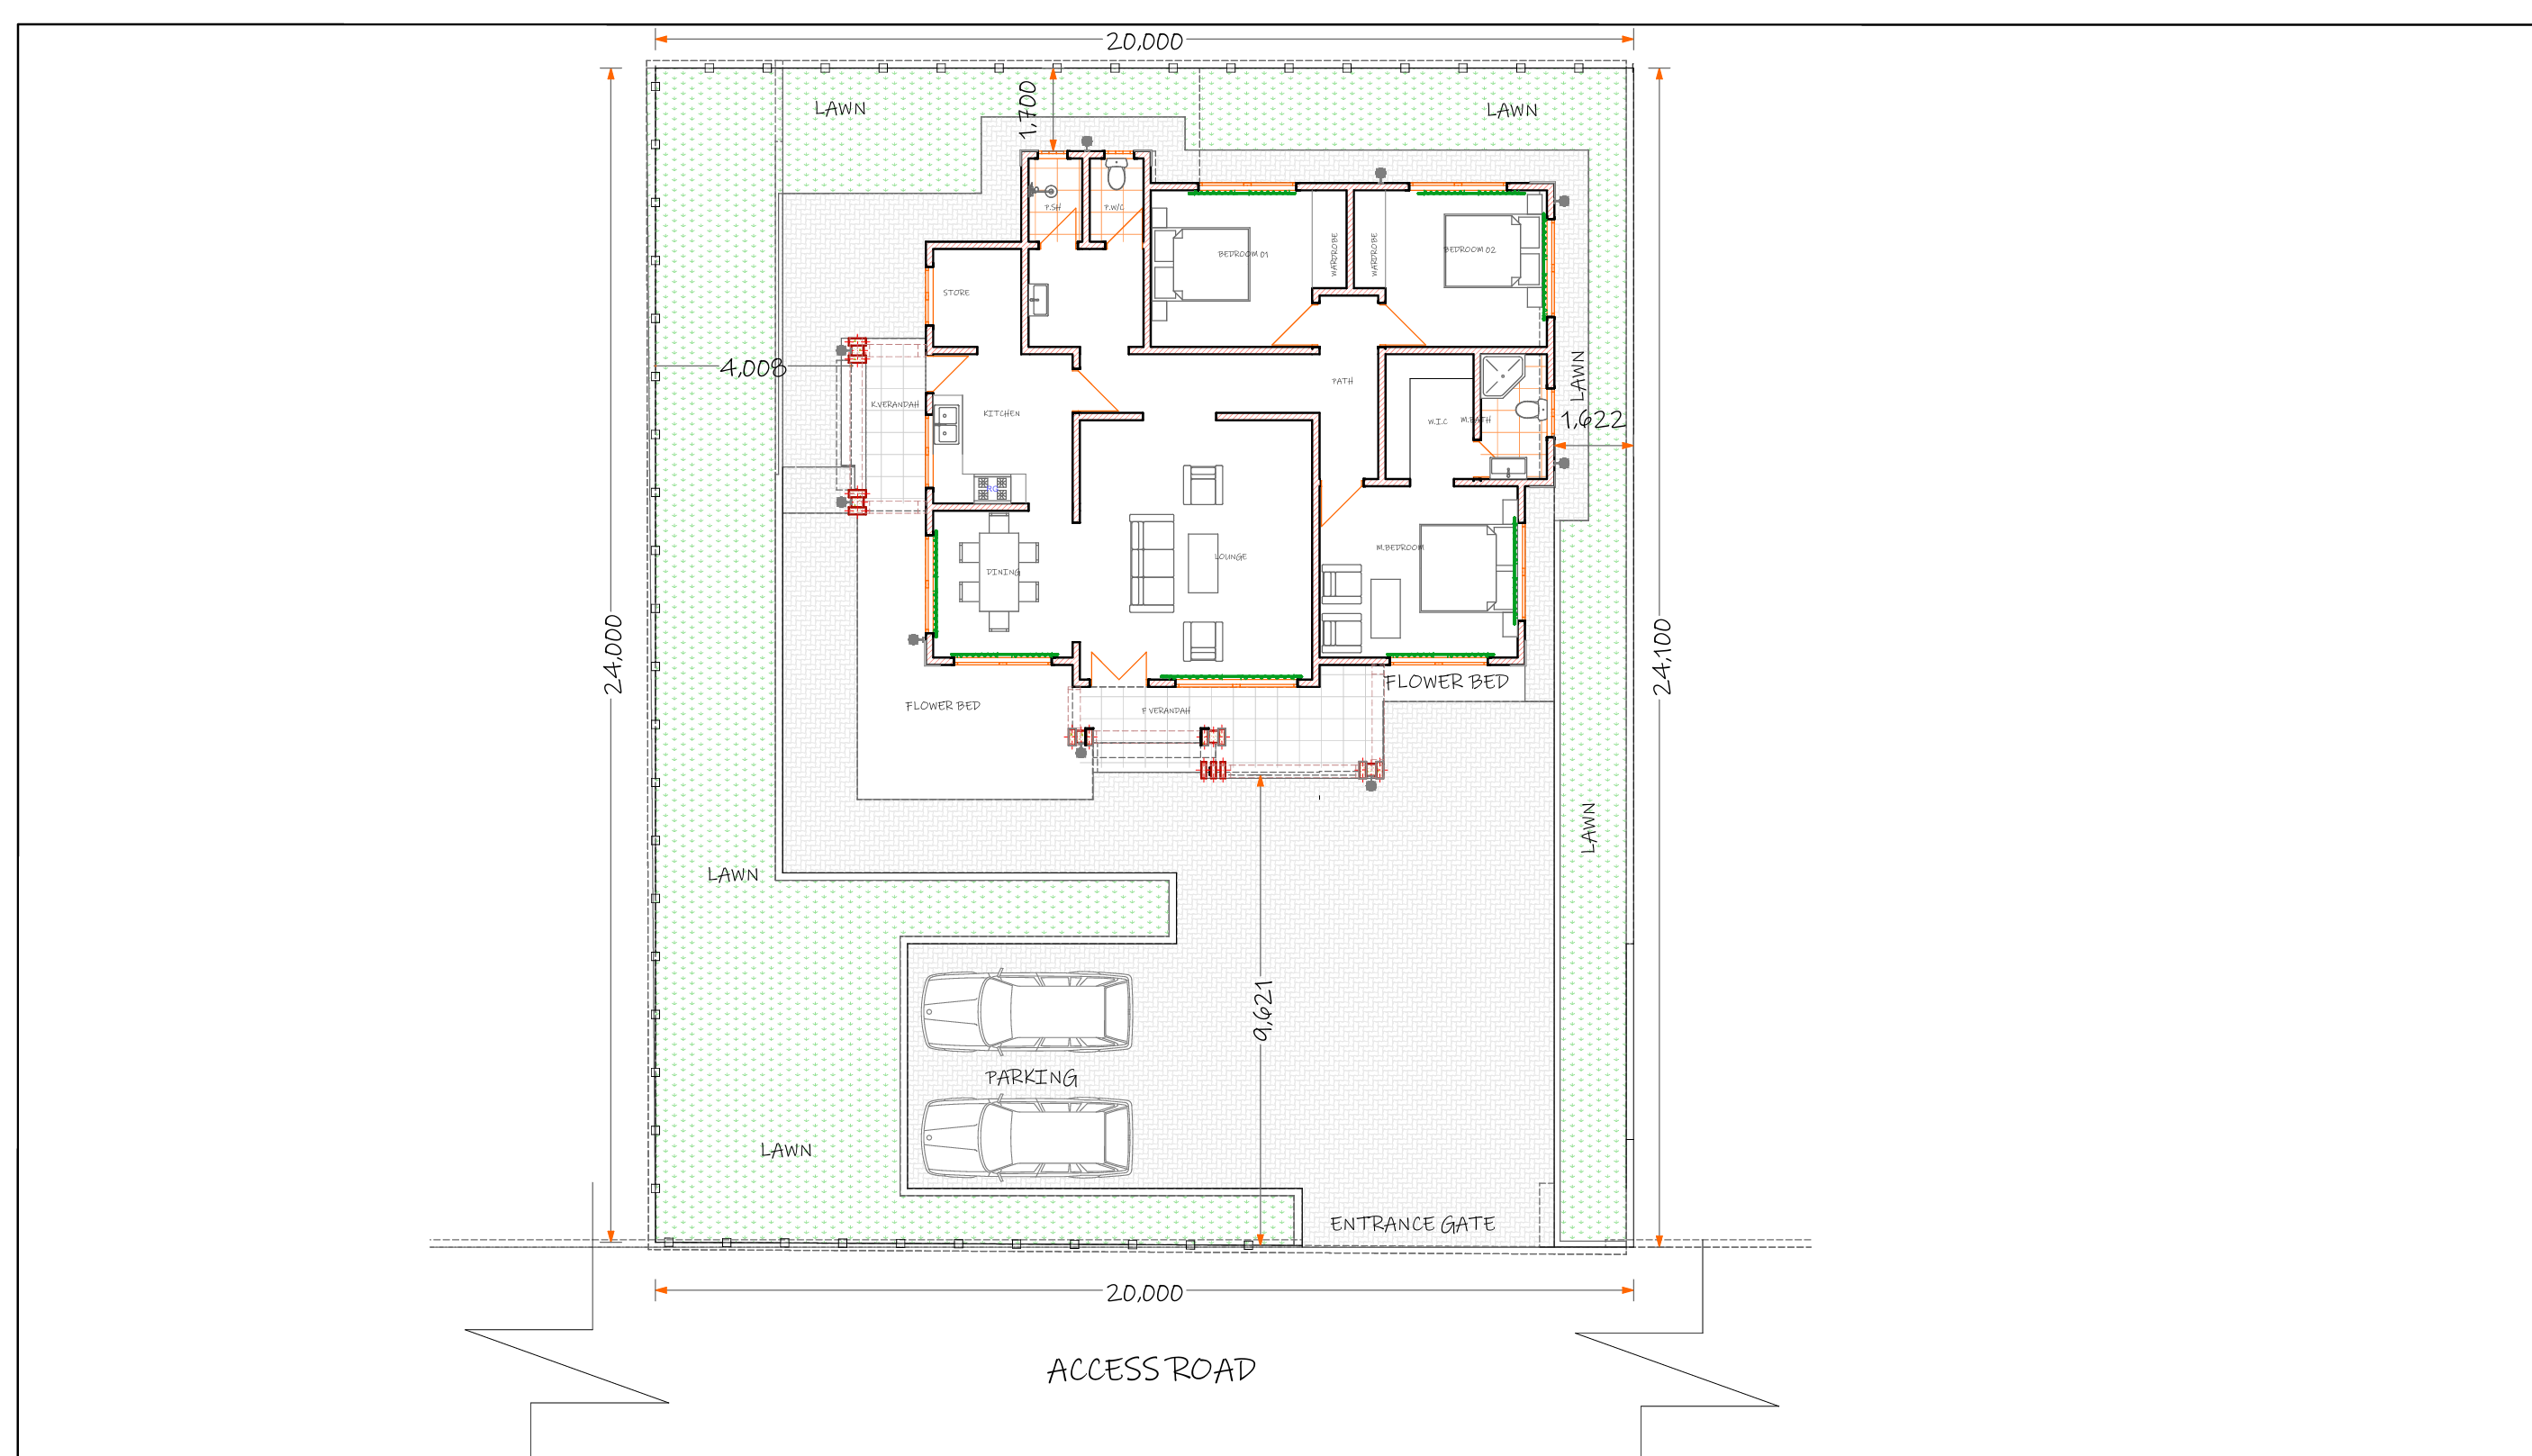

In [6]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path)
display(img)

In [8]:
questions = [
    "How many bedrooms are in this floor plan?",
    "How many bathrooms or WC are shown?",
    "How many parking spaces for cars?",
    "What is the plot width in meters?",
    "What is the plot depth in meters?",
    "What is the total area in square meters?",
    "How many lawn areas are there?",
    "List all the rooms you can identify with their names."
]

In [18]:
answers = {}
for i, question in enumerate(questions, 1):
    print(f"\nProcessing Q{i}: {question}")
    answer = ask_question(image_path, question)
    answers[question] = answer
    display(Markdown(f"**Answer:** {answer}"))


Processing Q1: How many bedrooms are in this floor plan?


**Answer:** The floor plan shows **three bedrooms**.

Here's how they are identified:

1. **Bedroom 21** – Located in the upper left section of the house.
2. **Bedroom 22** – Located in the upper right section of the house.
3. **Master Bedroom** – Located in the lower right section of the house, marked as "M. BEDROOM."

Each bedroom has an associated bathroom (ensuite or shared), and the layout clearly distinguishes these rooms from other spaces like the living area, kitchen, and dining area.


Processing Q2: How many bathrooms or WC are shown?


**Answer:** The floor plan shows **2 bathrooms (WCs)**.

Here's how they can be identified:

1. **First Bathroom**: Located near the top-left corner of the house, adjacent to the kitchen and living area. It includes fixtures such as a toilet and a sink, indicated by standard symbols.

2. **Second Bathroom**: Positioned in the top-right section, attached to one of the bedrooms (labeled "BEDROOM 02"). It also contains a toilet and sink, with a shower or bath, indicated by the symbols.

These two are clearly marked in the layout, and no other bathroom fixtures are shown. Thus, the total number of bathrooms/WCs is **2**.


Processing Q3: How many parking spaces for cars?


**Answer:** Based on the floor plan provided, there are **2 parking spaces** for cars. This is indicated by the two car symbols in the designated "PARKING" area near the entrance gate.


Processing Q4: What is the plot width in meters?


**Answer:** The plot width in the image is **20.000 meters**.

This is indicated by the horizontal dimension labeled at the top and bottom of the plot, which shows the width of the entire site from one side to the other.


Processing Q5: What is the plot depth in meters?


**Answer:** The plot depth in the provided floor plan is **24.000 meters**.

This is indicated by the vertical dimension on the left and right sides of the plot, labeled as **24.000**. This measurement represents the depth of the entire plot from the front (near the access road) to the back.


Processing Q6: What is the total area in square meters?


**Answer:** To calculate the **total area in square meters** of the property shown in the floor plan, we need to determine the **overall dimensions** of the plot and multiply them.

From the diagram:

- The **length** of the plot is **24.00 meters** (vertical dimension).
- The **width** of the plot is **20.00 meters** (horizontal dimension).

### Total Area:
$$
\text{Area} = \text{Length} \times \text{Width} = 24.00 \, \text{m} \times 20.00 \, \text{m} = 480.00 \, \text{m}^2
$$

### ✅ Total area = **480.00 square meters**

This includes the house, lawns, parking, flower beds, and all land within the boundary.


Processing Q7: How many lawn areas are there?


**Answer:** There are **four** lawn areas in the provided floor plan.

They are located in the following positions:

1. **Top-left** corner of the property.
2. **Top-right** side of the house.
3. **Bottom-left** side of the property (adjacent to the parking area).
4. **Right side** of the house, extending vertically along the right edge.

These areas are labeled "LAWN" in the plan and are separated by built structures and access roads.


Processing Q8: List all the rooms you can identify with their names.


**Answer:** Based on the floor plan provided, here are the rooms and areas that can be identified:

1. **Living Room** – Located centrally in the house, with a sofa and coffee table layout.
2. **Dining Area** – Adjacent to the living room, with a dining table and chairs.
3. **Kitchen** – Positioned near the dining area, with sink, stove, and cabinets.
4. **Pantry** – Connected to the kitchen.
5. **Bedroom 1** – Located at the top right of the plan.
6. **Bedroom 2** – Located next to Bedroom 1, on the upper floor.
7. **Bedroom 3 (Master Bedroom)** – On the right side of the lower floor, with attached bathroom and dressing area.
8. **Bathroom 1** – Adjacent to Bedroom 1 and Bedroom 2.
9. **Bathroom 2 (attached to Master Bedroom)** – Also includes a bathtub and shower.
10. **W.C. (Toilet)** – Located near the kitchen and accessible from the central circulation.
11. **Laundry Area** – Located off the kitchen.
12. **Entrance/Entryway** – The main entrance area leading into the house, near the central hall.
13. **Parking Area** – On the lower level, space for two cars.
14. **Front Lawn** – The outdoor area at the front of the house.
15. **Side Lawns** – On the left and right flanks of the house.
16. **Flower Beds** – Two flower beds on either side of the house near the entrance and rear.
17. **Garden** – The overall landscaped area surrounding the house, including lawns and flower beds.
18. **Access Road** – The external road leading to the entrance gate.
19. **Entrance Gate** – Gateway into the property leading to the parking and house.

These rooms and areas are derived from the labeled sections and layout shown in the floor plan.

In [43]:
query = """
Analyze this floor plan image and identify ALL rooms and spaces.
For each room/space, provide:
1. Room name/type (bedroom, bathroom, kitchen, living room, parking, lawn, etc.)
2. Approximate bounding box coordinates as percentages (0-100) in format: [x_min, y_min, x_max, y_max]
   where (0,0) is top-left corner and (100,100) is bottom-right corner

Return ONLY a valid JSON array with this exact format:
[
    {
        "name": "Bedroom 1",
        "bbox": [10, 20, 30, 40]
    },
    {
        "name": "Bathroom",
        "bbox": [35, 20, 45, 35]
    }
]

Be as accurate as possible with the coordinates by carefully examining the floor plan.
Include ALL visible rooms and spaces.
"""

rooms = analyze_floor_plan(image_path, query)
rooms = extract_json_from_response(rooms)

In [44]:
rooms

[{'name': 'Living Room', 'bbox': [581, 245, 787, 396]},
 {'name': 'Kitchen', 'bbox': [524, 224, 677, 390]},
 {'name': 'Dining Room', 'bbox': [568, 317, 631, 373]},
 {'name': 'Bedroom 1', 'bbox': [677, 120, 751, 199]},
 {'name': 'Bedroom 2', 'bbox': [834, 115, 912, 184]},
 {'name': 'Bedroom 3', 'bbox': [815, 300, 901, 376]},
 {'name': 'Bathroom 1', 'bbox': [618, 82, 683, 145]},
 {'name': 'Bathroom 2', 'bbox': [883, 218, 924, 261]},
 {'name': 'Bathroom 3', 'bbox': [818, 215, 864, 264]},
 {'name': 'Staircase', 'bbox': [626, 383, 695, 446]},
 {'name': 'Wardrobe', 'bbox': [757, 120, 791, 190]},
 {'name': 'Wardrobe', 'bbox': [619, 245, 635, 269]},
 {'name': 'Porch', 'bbox': [588, 388, 695, 429]},
 {'name': 'Parking', 'bbox': [535, 559, 701, 707]},
 {'name': 'Lawn', 'bbox': [383, 38, 970, 743]},
 {'name': 'Flower Bed', 'bbox': [532, 388, 637, 406]},
 {'name': 'Flower Bed', 'bbox': [817, 381, 916, 406]},
 {'name': 'Access Road', 'bbox': [257, 732, 1074, 748]},
 {'name': 'Entrance Gate', 'bbox'

In [45]:
for i, room in enumerate(rooms, 1):
    print(f"Room {i}: {room['name']}")

Room 1: Living Room
Room 2: Kitchen
Room 3: Dining Room
Room 4: Bedroom 1
Room 5: Bedroom 2
Room 6: Bedroom 3
Room 7: Bathroom 1
Room 8: Bathroom 2
Room 9: Bathroom 3
Room 10: Staircase
Room 11: Wardrobe
Room 12: Wardrobe
Room 13: Porch
Room 14: Parking
Room 15: Lawn
Room 16: Flower Bed
Room 17: Flower Bed
Room 18: Access Road
Room 19: Entrance Gate


In [88]:
contours, cv_img = detect_rooms(image_path)

In [89]:
matched_rooms = match_contours_to_rooms(contours, rooms)

In [90]:
matched_rooms

[{'name': 'Living Room',
  'bbox': [581, 245, 787, 396],
  'source': 'ai_fallback'},
 {'name': 'Kitchen', 'bbox': [524, 224, 677, 390], 'source': 'ai_fallback'},
 {'name': 'Dining Room',
  'bbox': [568, 317, 631, 373],
  'source': 'ai_fallback'},
 {'name': 'Bedroom 1', 'bbox': [677, 120, 751, 199], 'source': 'ai_fallback'},
 {'name': 'Bedroom 2', 'bbox': [834, 115, 912, 184], 'source': 'ai_fallback'},
 {'name': 'Bedroom 3', 'bbox': [815, 300, 901, 376], 'source': 'ai_fallback'},
 {'name': 'Bathroom 1', 'bbox': [618, 82, 683, 145], 'source': 'ai_fallback'},
 {'name': 'Bathroom 2', 'bbox': [883, 218, 924, 261], 'source': 'ai_fallback'},
 {'name': 'Bathroom 3', 'bbox': [818, 215, 864, 264], 'source': 'ai_fallback'},
 {'name': 'Staircase', 'bbox': [626, 383, 695, 446], 'source': 'ai_fallback'},
 {'name': 'Wardrobe', 'bbox': [757, 120, 791, 190], 'source': 'ai_fallback'},
 {'name': 'Wardrobe', 'bbox': [619, 245, 635, 269], 'source': 'ai_fallback'},
 {'name': 'Porch', 'bbox': [588, 388, 695,

In [91]:
refined_rooms = sift(image_path, matched_rooms)

In [92]:
refined_rooms

[{'name': 'Living Room', 'bbox': [708, 245, 787, 396], 'keypoints': 160},
 {'name': 'Kitchen', 'bbox': [524, 224, 677, 390], 'keypoints': 0},
 {'name': 'Dining Room', 'bbox': [568, 317, 631, 373], 'keypoints': 0},
 {'name': 'Bedroom 1', 'bbox': [707, 120, 749, 199], 'keypoints': 47},
 {'name': 'Bedroom 2', 'bbox': [834, 115, 912, 184], 'keypoints': 50},
 {'name': 'Bedroom 3', 'bbox': [815, 300, 868, 376], 'keypoints': 47},
 {'name': 'Bathroom 1', 'bbox': [618, 82, 683, 145], 'keypoints': 0},
 {'name': 'Bathroom 2', 'bbox': [883, 218, 924, 261], 'keypoints': 0},
 {'name': 'Bathroom 3', 'bbox': [818, 215, 856, 264], 'keypoints': 27},
 {'name': 'Staircase', 'bbox': [626, 383, 695, 446], 'keypoints': 0},
 {'name': 'Wardrobe', 'bbox': [758, 120, 791, 187], 'keypoints': 9},
 {'name': 'Wardrobe', 'bbox': [619, 245, 635, 269], 'keypoints': 0},
 {'name': 'Porch', 'bbox': [588, 388, 695, 429], 'keypoints': 0},
 {'name': 'Parking', 'bbox': [535, 559, 701, 707], 'keypoints': 2},
 {'name': 'Lawn', 

In [93]:
segments, annotated = segment(image_path, refined_rooms)

Processing Living Room: 142.20000000000005x271.80000000000007 pixels
Processing Kitchen: 275.4000000000001x298.8 pixels
Processing Dining Room: 113.39999999999998x100.79999999999995 pixels
Processing Bedroom 1: 75.59999999999991x142.2 pixels
Processing Bedroom 2: 140.4000000000001x124.19999999999999 pixels
Processing Bedroom 3: 95.40000000000009x136.80000000000007 pixels
Processing Bathroom 1: 117.0x113.4 pixels
Processing Bathroom 2: 73.79999999999995x77.39999999999998 pixels
Processing Bathroom 3: 68.39999999999986x88.19999999999999 pixels
Processing Staircase: 124.20000000000005x113.40000000000009 pixels
Processing Wardrobe: 59.399999999999864x120.60000000000002 pixels
Processing Wardrobe: 28.799999999999955x43.19999999999999 pixels
Processing Porch: 192.5999999999999x73.80000000000007 pixels
Processing Parking: 298.79999999999995x266.4000000000001 pixels
Processing Lawn: 554.3999999999999x1269.0 pixels
Processing Flower Bed: 189.0000000000001x32.40000000000009 pixels
Processing Flo

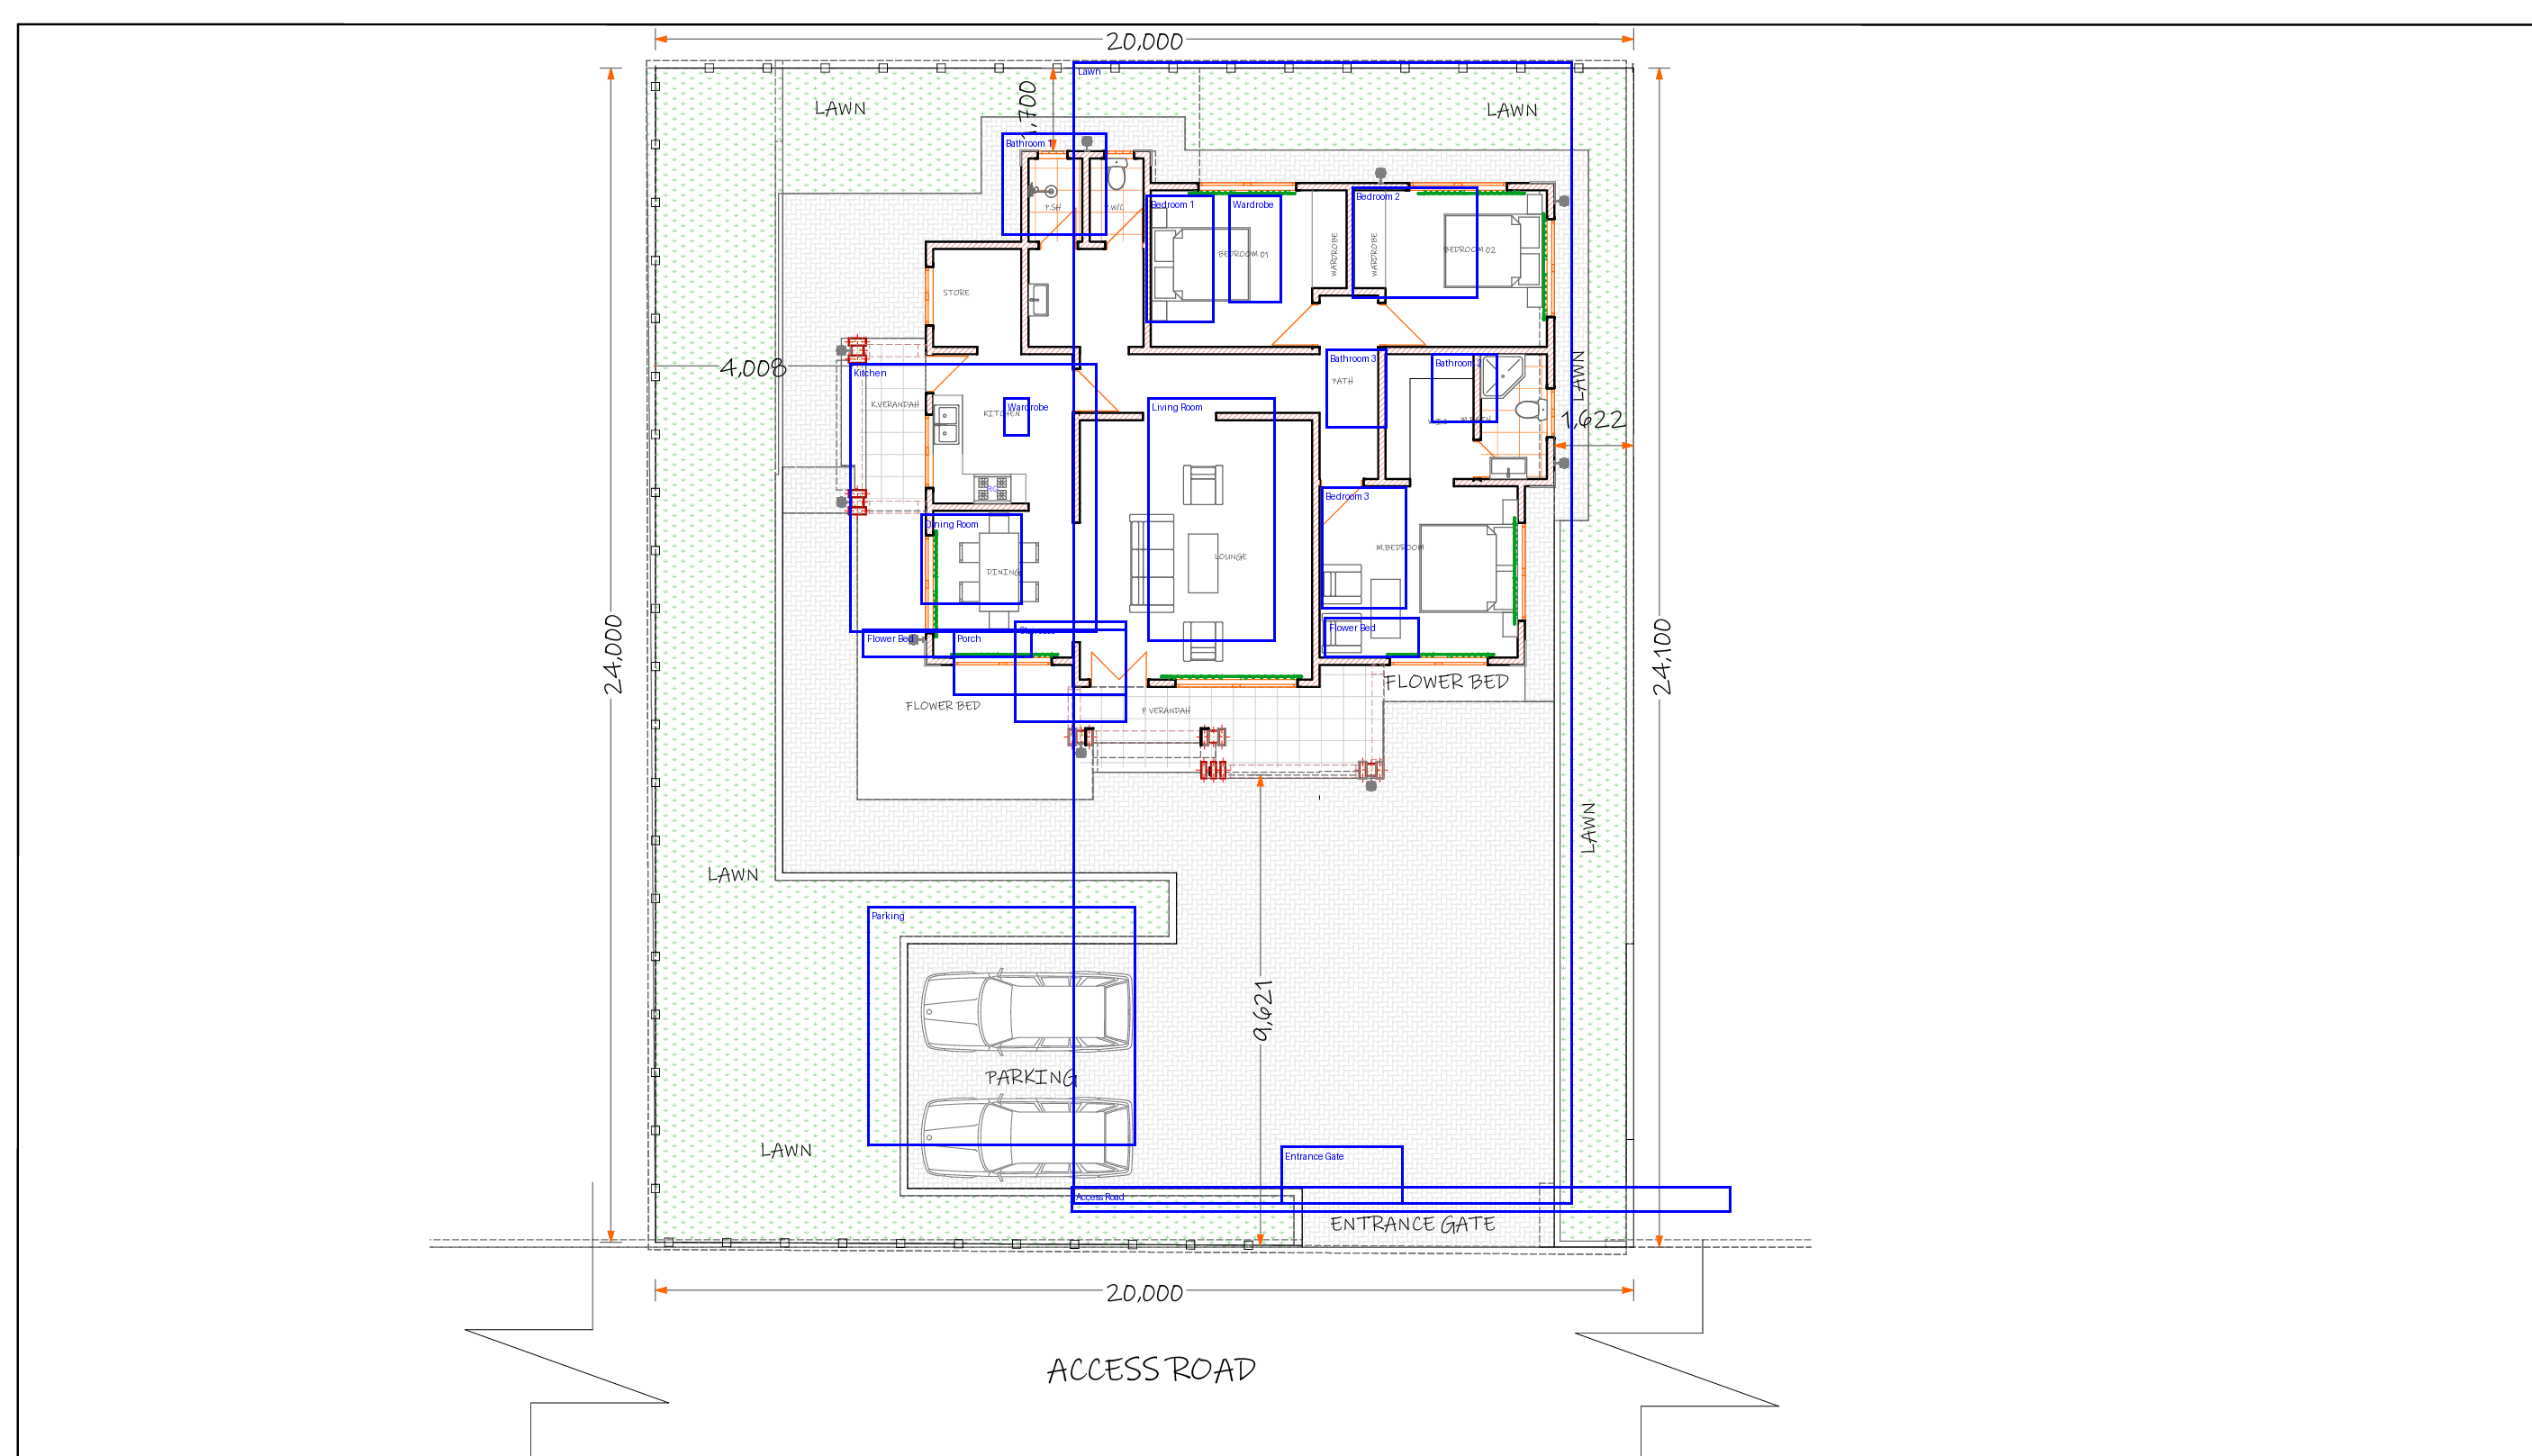

In [94]:
annotated